<a href="https://colab.research.google.com/github/MrBigBrane/Machine-Learning/blob/main/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import TensorDataset,DataLoader,random_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define the transformations to apply to the data
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
cifdata = torchvision.datasets.CIFAR10(root='cifar10',download=True, transform=transform)

Files already downloaded and verified


In [ ]:
print(cifdata.data.shape)

images = torch.tensor(cifdata.data).permute(0, 3, 1, 2).float()
print('\nTensor data:')
print(images.shape)  # Output: (50000, 3, 32, 32)

(50000, 32, 32, 3)

Tensor data:
torch.Size([50000, 3, 32, 32])


In [ ]:
labels = torch.tensor(cifdata.targets)
print(labels.shape)

torch.Size([50000])


Split data

In [ ]:
partitions = [.8,.1,.1]

# split the data (note the third input, and the TMP in the variable name)
train_data,testTMP_data, train_labels,testTMP_labels = \
                   train_test_split(images, labels, train_size=partitions[0])

# now split the TMP data
split = partitions[1] / np.sum(partitions[1:])
devset_data,test_data, devset_labels,test_labels = \
              train_test_split(testTMP_data, testTMP_labels, train_size=partitions[1])

In [ ]:
train_data = TensorDataset(train_data,train_labels)
dev_data   = TensorDataset(devset_data,devset_labels)
test_data  = TensorDataset(test_data,test_labels)

train_loader = DataLoader(train_data,batch_size=32,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cifar10net(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(3,12,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(12) # input the number of channels in this layer
      # output size: (32+2*1-3)/1 + 1 = 32/2 = 16 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(12,48,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(48) # input the number of channels in this layer
      # output size: (16+2*1-3)/1 + 1 = 16/2 = 8 (/2 b/c maxpool)

      # third convolution layer
      self.conv3  = nn.Conv2d(48,192,3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(192) # input the number of channels in this layer
      # output size: (16+2*1-3)/1 + 1 = 16/2 = 8 (/2 b/c maxpool)

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(4*4*192,50)
      self.fc2 = nn.Linear(50,26)

      self.dropout = nn.Dropout(.5)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.relu(self.bnorm3(x))
      if self.print: print(f'Third CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = self.dropout(x)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cifar10net(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First CPR block: [32, 12, 16, 16]
Second CPR block: [32, 48, 8, 8]
Third CPR block: [32, 192, 4, 4]
Vectorized: [32, 3072]
Final output: [32, 26]

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.4852, grad_fn=<NllLossBackward0>)


In [ ]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  devErr    = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    devLoss[epochi] = loss.item()
    devErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs
  net.eval()
  X,y = next(iter(test_loader)) # extract X,y from test dataloader

  # push data to GPU
  X = X.to(device)
  y = y.to(device)

  with torch.no_grad(): # deactivates autograd
    yHat = net(X)
    loss = lossfun(yHat,y)

  # get loss and error rate from the test batch
  testLoss[epochi] = loss.item()
  testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # function output
  return trainLoss,devLoss, testLoss,trainErr, devErr, testErr,net

In [ ]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss, devLoss, testLoss, trainErr, devErr, testErr,net = function2trainTheModel()

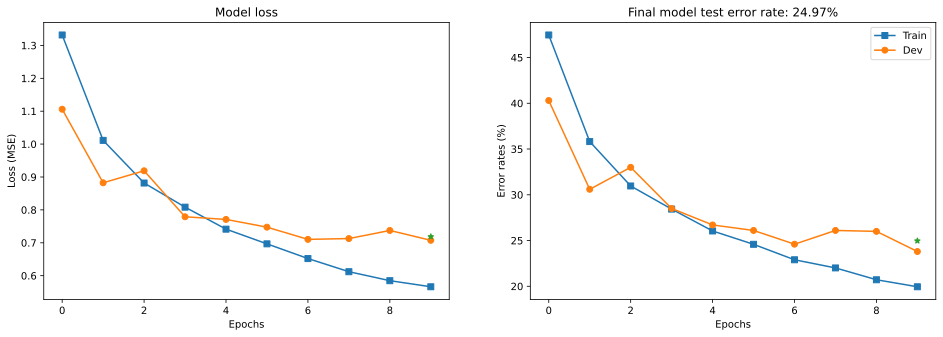

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot([9], testLoss[-1], marker='*')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(devErr,'o-',label='Dev')
ax[1].plot([9], testErr[-1], marker='*')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()